# "Variational Autoencoders"

> "Variational Autoencoders (VAEs) have been covered in many different texts and blog posts. The goal here is not so much to repeat the information covered by so many others but instead to look at the VAE with the goal of introducing Dynamical Variational Autoencoders (DVAEs) later. Ultimately the aim is to cover how learn latent dynamics that describe the behaviour of complex systems. *Note, on the off chance someone is actually reading this (thank you for your interest) but this is my first blog post and so this content may change as I experiment with features and use this notebook as a prototype for future posts. So consider this a draft post for now" 

- toc: true 
- badges: true 
- comments: true 
- author: Marco Star 

In [1]:
#hide
from IPython.display import Image

## A Simple Example

A benefit of VAEs is that they can take input values ($X$) and map them to a lower dimensional latent variable ($Z$). We will look at an example to show this more clearly; it will also be used in a later post to show how to model latent dynamics of systems with a lot of input variables {% fn 1 %}. The example shown below is a mass that is suspended from the ceiling. Imagine I pull it in the $z$-direction and let go. You probably imagine the mass will bob up and down but imagine we don't know that. Instead, we are alien scientists trying to uncover the hidden dynamics of this complex system we have never seen before. So we set up $n$ cameras or motion sensors all around the room (where $n$ is just some arbitrary number). Each sensor provides a different axis or perspective describing the motion of the spring-mass system. 

{{'I took this example/analogy from a [linear alegbra course by Nathan Kutz](https://www.youtube.com/watch?v=a9jdQGybYmE) to describe dimension reduction for Principal Component Analysis. I however, altered and extended the analogy to suit my purposes for explaining VAEs (and ultimately DVAEs and discovering the latent dynamics high dimensional of systems)' | fndetail: 1}}


In [2]:
Image(url="images/mass_spring_VAE.png", width=600, height=600)

Let us formally define inputs $X = [x_1, x_2, x_3, ..., x_n]$ which are our sensor readings. In fact, to get an idea of the complexity of the dynamics let us plot what some of these sensor readings may look like. We will say the spring mass system is modelled as,

$$
    z(t) = z_0 \text{cos}\left(\sqrt{\frac{k}{m}} t\right)
$$
where we will simply assume, $z_0=k=m=1$ (initial position, spring constant and mass equal 1).
For plotting what the sensor reading may look like, we will assume that the sensors are randomly located around the spring-mass system. The sensors will return the distance between the mass and the sensor as it is in motion. Hence, we will randomly define the Cartesian coordinates of the sensors in the room and simply take the distance between the moving spring-mass system and the sensor locations as the sensor outputs. 


In [1]:
#collapse-hide
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb 

%matplotlib inline 
sb.set_theme()

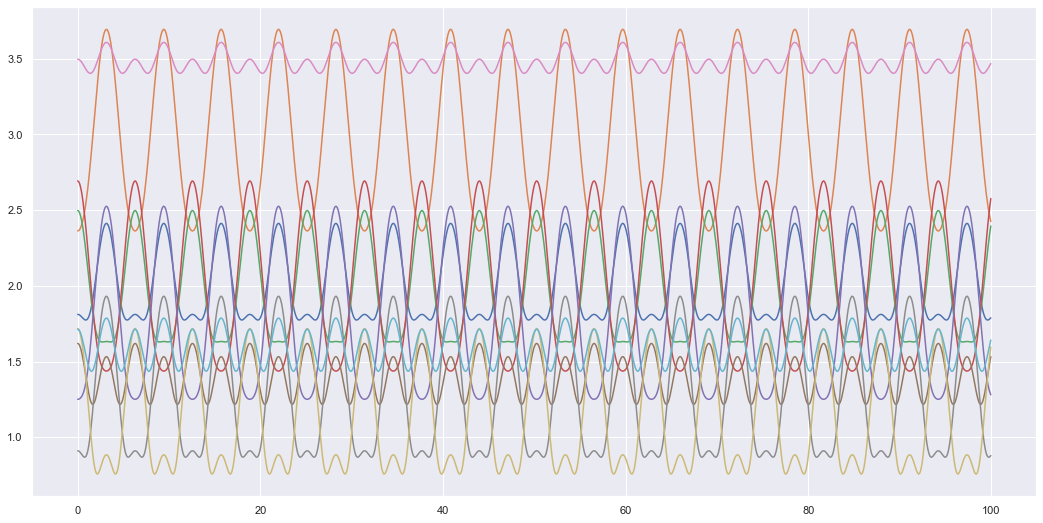

In [6]:
#collapse-hide
def get_sensor_values(n, t_min, t_max, res=100, m=1., k=1., z0=1.):
    t = np.linspace(t_min, t_max, res)
    z = z0*np.cos(np.sqrt(k/m) * t)     # spring mass motion along the z-axis 

    # coordinates of sensors in a cartesian plane (origin is when z=0 before spring-mass system is stretched)
    x_sen = np.random.normal(size=[n, 1]) 
    y_sen = np.random.normal(size=[n, 1])   
    z_sen = np.random.normal(size=[n, 1])   

    z_diff = z - z_sen  # only difference in the z-axis
    xs = np.sqrt(x_sen**2 + y_sen**2 + z_diff**2)

    return t, xs.T     # shape (time, n)

t, X = get_sensor_values(10, 0, 100, res=1000)

plt.figure(figsize=(18,9))
plt.plot(t, X)
plt.show()

We get some relatively weird looking data at least compared to the simple oscillating motion we would get if we only looked at the z-axis motion. The aim of the VAE is to find that simple oscillating motion from the data collected by all these sensors. With this simple system that we can compress all the input data $X$ into a more simple latent space $Z$. In this latent space the motion isn't as complex and only requires 1 axis to fully describe the motion. The idea of the VAE is to represent high dimensional data in a representative latent space $Z$ which tries to efficiently encode the input data into a lower dimensional space (in this case the latent space $Z$ would fully be able to describe the motion of the system). But how does the VAE do this? 

## The Components of the VAE 

The VAE is a generative model. This means instead of simply learning an input $\rightarrow$ output relationship e.g. $f(X) = Z$ or using probability distributions $p(Z|X)$, we learn the joint probability between the inputs and latent variables $p(X,Z)$. This allows us to transfer from one space to another as $p(X,Z) = p(Z|X)p(X)=p(X|Z)p(Z)$ it also lets us generate inputs $X$ simply by sampling the latent space $Z$ and using $p(X|Z)$ to generate new inputs $X$. But how does the VAE do this? 

Firstly, if the goal is to model the joint distribution $p(X,Z)$ which can be described using $p(X,Z) = p(Z|X)p(X)=p(X|Z)p(Z)$, then since this is deep learning, let us model what we can using neural networks. We then have,

* $p(Z|X) = q_{\phi}(Z|X)$ is the encoder network as it encodes inputs to the latent space. $\phi$ are the parameters of the network and in most cases it models a Gaussian/Normal distribution by making the network output a mean and log-variance i.e. $q_{\phi}(Z|X) = [\mu_z, \text{log}\sigma_z^2]$
* $p(X|Z) = p_{\theta_x}(X|Z)$ is the decoder as it takes latent variables and transforms them back into the input space. The network parameters are $\theta_x$ and it models a Gaussian distribution like the encoder 
* $p(Z) = p_{theta_z}(Z)$ for VAEs this isn't usually a network but instead we define it as a standard normal distribution $\mathcal{N}(0,I)$. The idea behind this is that we constain the latent space to this domain so after training we don't need the encoder to tell us where the latent variables exist. Instead, we just sample from the defined distribution $Z \sim \mathcal{N}(0,I)$ and decode to the input space to generate new input data. 
* $p(X)$ this is the distribution of the input data, we don't know what this is and that is the motivation for trying our very best to get rid of it in any formula we see (out of sight out of mind). We will use all sorts of mathematical tricks to derive a loss function which does not include this term. 

To train the VAE first notice that the encoding distribution can be expressed in the following form.

$$
    p(Z|X) = \frac{p(X|Z)p(Z)}{p(X)}
$$

Since we don't know what $p(X)$ is we use variational techniques to estimate the unknown distribution $p(Z|X)$ using a simpler distribution (usually a Gaussian distribution). Hence, we have,

$$
    p(Z|X) \approx q_{\phi}(Z|X) = [\mu_z, \text{log}\sigma_z^2] \rightarrow \mathcal{N}(\mu_z, \sigma_z^2)
$$

To derive the loss (known as the Evidence Lower Bound or ELBO) we try to minimise the difference between the simple distribution $q_\phi(Z|X)$ and the complex unknown $p(Z|X)$. 
i.e.
$$
    D_{KL}(q_\phi(Z|X)||p(Z|X))
$$
Where $D_{KL}$ is the KL-divergance. 

There are many resources which derive the ELBO, so I won't go over the mathematical details. I will however show the final form of the ELBO and discuss the logic behind each term so that it may become clear how we can later leverage this to learn the latent dynamics of the system (when looking at DVAEs). 

$$
    \text{ELBO} = \mathbb{E}_{q_{\phi}(Z|X)}\left[\text{log} p_{\theta_x}(X|Z)\right] - D_{KL}\left( q_{\phi}(Z|X) || p(Z)\right)
$$

To optimise this we maximise the ELBO (or we minimise the -ELBO) loss by tuning the parameters network parameters $\phi$ and $\theta_x$. Let's look at the first term,
$$
    \mathbb{E}_{q_{\phi}(Z|X)}\left[\text{log} p_{\theta_x}(X|Z)\right]
$$ 

This is the log-likelihood which determines the likelihood of the decoded latent variable $Z$ to match the target input $X$. This is what we might think of when we think of a traditional or basic loss function; is the output of our network close to the target output we expect. The more interesting term here is the second one, 

$$
    D_{KL}\left( q_{\phi}(Z|X) || p(Z)\right)
$$

This term optimises $q_{\phi}(Z|X)$ to encode the latent variables $Z$ into a defined space $p(Z)$ (for VAEs this is commonly described using the standard normal distribution). This means an optimised VAE has a latent space constrained to the prior distribution $p(Z)$. Hence, we could theoretically design a simple prior (this is what we do by picking a standard normal distribution) and simplify the latent space, so it is easy to interpret.

## Problems 

For learning the underlying dynamics of sequential input data the VAE is not the ideal model. One problem we have is that $Z$ and $X$ are fixed lengths. If we want to learn the dynamics we don't it is not very useful if we can only deal with sequences of a certain arbitrary length that we choose to train with. 
e.g. if we trained with input time-series sequences of length $T$, $X = [x_1,...,x_T]$, then we can only reconstruct other $X$ variables of the same length. Hence, if $X$ denotes a list of positions then we are only outputting possible positions the spring-mass system could be in and not understanding the physics or dynamics behind how those positions came about. 
So VAEs can handle "static" cases where the data is a fixed length or size (e.g. generating images). However, if we want to learn the dynamics of the system we need to be able to handle the dynamic case. In this dynamic case the data could have different sequence lengths, but even if it isn't, we don't want to just learn all the possible positions of the spring-mass system, we also want to understand the underlying dynamics that determine how those positions change over time. 
Another problem is the prior of the VAE is generally a Gaussian distribution with zero mean and unit variance (standard Normal distribution). This is not ideal if we want to learn a sequence as the latent space has no sequential structure. If we use a standard Normal distribution then we are trying to construct a latent sequence which consists of sequences of randomly generated variables that have no relation to each other with respect to time i.e. 

$$
    z_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

Hence, the latent space consists of sequences ${z_t}_{t=0}^T$ where each $z_t$ was randomly generated and is not related to any other $z_t$ variable. This type of prior is not conducive to building structured latent dynamics. But what can be done to tackle these problems? 

What we want is to replace the components of the VAE so it looks something like this, 

* Encoder: $q_{\phi}(Z|X) = q_{\phi}(z_t|z_{1:t-1},x_{1:t})$ (later when looking at DVAEs we will learn this isn't quite right)
* Decoder: $p_{\theta_x}(X|Z) = p_{\theta_x}(x_t|x_{1:t-1}, z_{1:t})$
* Prior: $p(Z) = p_{\theta_z}(z_t|z_{t-1})$

We could then design some simple prior dynamics and given an initial $z_0$ use $p_{\theta_z}(z_t|z_{t-1})$ to generate any sequence of arbitrary length. To design a VAE that does this is known as a DVAE and we will see that it is just the VAE but simplified (mathematically speaking not conceptually) to deal with sequences. 